# VGG16

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
MODEL_ID = "fast_vgg16_test"

TRAIN_DIR = Path("../../data/sample")
MODEL_DIR = Path("./models")
LOG_DIR = Path("./log")
CACHE_DIR = Path("./tmp/cache")
CHKPT_DIR = Path("./tmp/chkpt")

BATCH_SIZE = 64
VAL_SPLIT = 0.25
IMG_HEIGHT = IMG_WIDTH = 224
GPU_MEMORY_LIMIT = None
SEED = 1

NUM_EPOCHS = 5
INITIAL_EPOCH = 0
LOAD_MODEL_PATH = None

In [3]:
# Remove cache directory if available
if CACHE_DIR.exists():
    shutil.rmtree(CACHE_DIR, ignore_errors = True)

MODEL_DIR.mkdir(parents = True, exist_ok = True)
LOG_DIR.mkdir(parents = True, exist_ok = True)
CACHE_DIR.mkdir(parents = True, exist_ok = True)
CHKPT_DIR.mkdir(parents = True, exist_ok = True)

In [4]:
# Set global seed for reproducible results
tf.random.set_seed(SEED)

In [5]:
# Limit GPU Memory Usage to GPU_MEMORY_LIMIT
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus and GPU_MEMORY_LIMIT:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = GPU_MEMORY_LIMIT)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

## Loading Images

In [6]:
X_train, X_test = train_test_split(
    list(TRAIN_DIR.glob("**/*.jpg")),
    test_size = VAL_SPLIT,
    random_state = SEED
)

train_filepaths = []
train_classes = set()

val_filepaths = []
val_classes = set()

for filepath in X_train:
    train_filepaths.append(str(filepath))
    train_classes.add(filepath.parts[-2])
print("Train: Found {} images belonging to {} classes".format(len(train_filepaths), len(train_classes)))
    
for filepath in X_test:
    val_filepaths.append(str(filepath))
    val_classes.add(filepath.parts[-2])
print("Validation: Found {} images belonging to {} classes".format(len(val_filepaths), len(val_classes)))
    
train_filepaths = np.array(train_filepaths)
val_filepaths = np.array(val_filepaths)

classes = np.array(list(train_classes.union(val_classes)))
classes = np.sort(classes)

Train: Found 12600 images belonging to 42 classes
Validation: Found 4200 images belonging to 42 classes


In [7]:
train_fp_ds = tf.data.Dataset.from_tensor_slices(train_filepaths)
for f in train_fp_ds.take(3):
    print(f.numpy())

b'..\\..\\data\\sample\\25\\496e1f2e0886bd18e28cfff6fa7fe7ac.jpg'
b'..\\..\\data\\sample\\22\\282ca2cb62eb90d4aeeac1de79f3a126.jpg'
b'..\\..\\data\\sample\\31\\4b84f4319802acc8c30db0de5a047de9.jpg'


In [8]:
val_fp_ds = tf.data.Dataset.from_tensor_slices(val_filepaths)
for f in val_fp_ds.take(3):
    print(f.numpy())

b'..\\..\\data\\sample\\13\\d41d36717655c70a18fea55f83cc9d0b.jpg'
b'..\\..\\data\\sample\\33\\902507eff4f11806b2c77e422da3ffdd.jpg'
b'..\\..\\data\\sample\\13\\56005da6d1655b445820aa2054567dd0.jpg'


In [9]:
def load_img(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] == classes
    
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]) 
    
    return img, label

In [10]:
train_img_ds = train_fp_ds.map(load_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
for image, label in train_img_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False]


In [11]:
val_img_ds = val_fp_ds.map(load_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
for image, label in val_img_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


## Image Preprocessing

In [14]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img, seed = SEED)
#     img = tf.image.random_brightness(img, max_delta = 0.4, seed = SEED)
#     img = tf.keras.preprocessing.image.random_zoom(img, 0.4)
    
    return img, label

In [15]:
processed_train_ds = train_img_ds \
                        .cache(str(CACHE_DIR / "train.tfcache")) \
                        .shuffle(BATCH_SIZE * 20, seed = SEED) \
                        .map(augment, num_parallel_calls = tf.data.experimental.AUTOTUNE) \
                        .repeat() \
                        .batch(BATCH_SIZE) \
                        .prefetch(tf.data.experimental.AUTOTUNE) \

TypeError: in user code:

    <ipython-input-14-630290f1f56a>:4 augment  *
        img = tf.keras.preprocessing.image.random_zoom(img, 0.4)
    C:\Users\Aloysius\anaconda3\lib\site-packages\keras_preprocessing\image\affine_transformations.py:145 random_zoom  *
        if len(zoom_range) != 2:
    C:\Users\Aloysius\anaconda3\lib\site-packages\tensorflow\python\autograph\operators\py_builtins.py:233 len_  **
        return _py_len(s)
    C:\Users\Aloysius\anaconda3\lib\site-packages\tensorflow\python\autograph\operators\py_builtins.py:278 _py_len
        return len(s)

    TypeError: object of type 'float' has no len()


In [14]:
processed_val_ds = val_img_ds \
                        .batch(BATCH_SIZE) \
                        .prefetch(tf.data.experimental.AUTOTUNE)

## Training Model

In [15]:
if not LOAD_MODEL_PATH:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.applications.VGG16(
            include_top = False,
            pooling = "avg",
            input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    ))
    model.add(tf.keras.layers.Dense(1024, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(len(classes), activation = "softmax"))
    
    model.layers[0].trainable = False
    for layer in model.layers[0].layers:
        layer.trainable = False

    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ["accuracy"]
    )
else:
    model = tf.keras.models.load_model(str(LOAD_MODEL_PATH))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 42)                43050     
Total params: 15,283,050
Trainable params: 568,362
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
checkpoint_path = CHKPT_DIR / (MODEL_ID + ".{epoch:03d}-{val_accuracy:.4f}.h5")
save_path = (MODEL_DIR / MODEL_ID).with_suffix(".h5")
log_path = (LOG_DIR / MODEL_ID).with_suffix(".csv")

print(checkpoint_path)
print(save_path)
print(log_path)

tmp\chkpt\fast_vgg16.{epoch:03d}-{val_accuracy:.4f}.h5
models\fast_vgg16.h5
log\fast_vgg16.csv


In [18]:
history = model.fit(
    processed_train_ds,
    epochs = NUM_EPOCHS,
    initial_epoch = INITIAL_EPOCH,
    steps_per_epoch = len(train_filepaths) // BATCH_SIZE,
    validation_data = processed_val_ds,
    validation_steps = len(val_filepaths) // BATCH_SIZE,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience = 10,
            restore_best_weights = True,
            verbose = 1,
            monitor = "val_accuracy",
            mode = "max"
        ),
        tf.keras.callbacks.CSVLogger(str(log_path), append = True),
        tf.keras.callbacks.ModelCheckpoint(
            str(checkpoint_path),
            monitor = "val_accuracy",
            mode = "max",
            save_best_only = True
        )
    ]
)

Epoch 11/15
1235/1235 [==============================] - 470s 381ms/step - loss: 1.2400 - accuracy: 0.6540 - val_loss: 1.4309 - val_accuracy: 0.6139
Epoch 12/15
1235/1235 [==============================] - 435s 352ms/step - loss: 1.2181 - accuracy: 0.6582 - val_loss: 1.4257 - val_accuracy: 0.6174
Epoch 13/15
1235/1235 [==============================] - 435s 352ms/step - loss: 1.1938 - accuracy: 0.6651 - val_loss: 1.4359 - val_accuracy: 0.6191
Epoch 14/15
1235/1235 [==============================] - 435s 352ms/step - loss: 1.1732 - accuracy: 0.6698 - val_loss: 1.4155 - val_accuracy: 0.6217
Epoch 15/15
1235/1235 [==============================] - 435s 352ms/step - loss: 1.2001 - accuracy: 0.6624 - val_loss: 1.4058 - val_accuracy: 0.6248


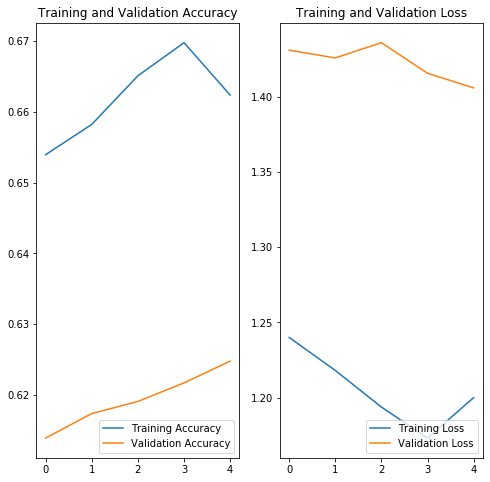

In [19]:
acc = history.history["accuracy"]
loss = history.history["loss"]
validation_acc = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

epochs_range = range(len(history.history["accuracy"]))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = "Training Accuracy")
plt.plot(epochs_range, validation_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = "Training Loss")
plt.plot(epochs_range, validation_loss, label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation Loss")
plt.show()

In [20]:
model.save(str(save_path), overwrite = False)

[WARNING] models\fast_vgg16.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


In [21]:
# Remove cache directory if available
if CACHE_DIR.exists():
    shutil.rmtree(CACHE_DIR, ignore_errors = True)